In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import os
import scipy.optimize as opt
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import confusion_matrix, classification_report 
import sklearn.linear_model as lin
from statsmodels.tools import add_constant
from matplotlib import rc,rcParams
rcParams['font.sans-serif'] = "Helvetica Neue LT Std"
rcParams['font.family'] = "sans-serif"

In [2]:
# styling for figures
#sns.set_style('white')
#sns.set_context('paper')
#sns.set_palette(sns.dark_palette('grey'))
#matplotlib.rcParams['xtick.labelsize'] = 14
#matplotlib.rcParams['ytick.labelsize'] = 14
#matplotlib.rcParams['axes.labelsize'] = 16
#matplotlib.rcParams['legend.fontsize'] = 14
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
#matplotlib.rcParams['mathtext.default'] = 'rm'
#matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
#matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
#matplotlib.rcParams['xtick.direction'] = 'in'
#matplotlib.rcParams['ytick.direction'] = 'in'
#matplotlib.rcParams['xtick.major.size'] = 0
#matplotlib.rcParams['ytick.major.size'] = 0

bayes_ci = .95
bmvs = lambda x: sts.bayes_mvs(x, alpha=bayes_ci)
#%matplotlib inline
direc = 'C:/Users/Bas/Google Drive/Bas Zahy Gianni - Games/Analysis/6_tur/Tur_yunqi (1)/'
direc2 = 'C:/Users/Bas/Google Drive/Bas Games/Analysis/Turing/'
fig_direc = 'C:/Users/Bas/Google Drive/Bas Zahy Gianni - Games/Manuscripts/Paper/Figures/'

In [3]:
movie_stats = pd.read_csv(direc + 'turing_movie_stats.csv')
videoinfo = pd.read_csv(direc + 'videoInfo.csv')
videoinfo = videoinfo[['id_data','length','length_b','length_w']]
vidLength = videoinfo.length.tolist()
# get average of Euclidean distances between points to measure scatteredness of the board
bps = movie_stats.bp.tolist()
wps = movie_stats.wp.tolist()

In [4]:
# not differentiating between players
pos = dict()
for i in range(len(movie_stats)):
    pos[i] = []
    for j in range(36):
        if (bps[i][j]=='1') or (wps[i][j]=='1'):
            pos[i].append(j)            

In [5]:
# differentiating between players
pos_bp = dict()
for i in range(len(movie_stats)):
    pos_bp[i] = []
    for j in range(36):
        if (bps[i][j]=='1'):
            pos_bp[i].append(j)            

In [6]:
pos_wp = dict()
for i in range(len(movie_stats)):
    pos_wp[i] = []
    for j in range(36):
        if (wps[i][j]=='1'):
            pos_wp[i].append(j)            

In [7]:
pos_bygame = dict()
c = 0
for i in range(180):
    pos_bygame[i]=[]
    for j in range(1,vidLength[i]+1,1):
        pos_bygame[i].append(list(set(pos[j])-set(pos[j-1]))[0])

In [8]:
pos_bygame_wp = dict()
c = 0
for i in range(180):
    pos_bygame_wp[i]=[]
    for j in range(1,vidLength[i]+1,1):
        if (list(set(pos_wp[j])-set(pos_wp[j-1]))!=[]):
            pos_bygame_wp[i].append(list(set(pos_wp[j])-set(pos_wp[j-1]))[0])

In [9]:
pos_bygame_bp = dict()
c = 0
for i in range(180):
    pos_bygame_bp[i]=[]
    for j in range(1,vidLength[i]+1,1):
        if (list(set(pos_bp[j])-set(pos_bp[j-1]))!=[]):
            pos_bygame_bp[i].append(list(set(pos_bp[j])-set(pos_bp[j-1]))[0])

In [10]:
# calculate pairwise Euclidean distances
loc_dict = dict()
loc_dict= {0:np.array((1,4)),1:np.array((2,4)),2:np.array((3,4)),3:np.array((4,4)),4:np.array((5,4)),
          5:np.array((6,4)),6:np.array((7,4)),7:np.array((8,4)),8:np.array((9,4)),
          9:np.array((9,3)),10:np.array((8,3)),11:np.array((7,3)),12:np.array((6,3)),13:np.array((5,3)),
          14:np.array((4,3)),15:np.array((3,3)),16:np.array((2,3)),17:np.array((1,3)),18:np.array((1,2)),
          19:np.array((2,2)),20:np.array((3,2)),21:np.array((4,2)),22:np.array((5,2)),23:np.array((6,2)),
           24:np.array((7,2)),25:np.array((8,2)),26:np.array((9,2)),27:np.array((9,1)),28:np.array((8,1)),
          29:np.array((7,1)),30:np.array((6,1)),31:np.array((5,1)),32:np.array((4,1)),33:np.array((3,1)),
           34:np.array((2,1)),35:np.array((1,1))}

In [11]:
dist = dict()
for i in range(180):
    dist[i] = 0
    n = len(pos_bygame[i])-1
    for j in range(n):
        dist[i] += np.linalg.norm(loc_dict[pos_bygame[i][j]] - loc_dict[pos_bygame[i][j+1]])

In [12]:
# get average Euclidean distance
dist_ave = dict()
for i in range(180):
    n = len(pos_bygame[i])-1
    dist_ave[i] = dist[i]/n if n>0 else 0

In [13]:
eucl_ave = pd.Series(dist_ave, name='ave_eucl')
eucl_ave.index.name = 'id_data'
eucl_ave.reset_index()
eucl_ave= pd.DataFrame(eucl_ave)

In [14]:
# load all data

In [15]:
vid_stats = pd.ExcelFile(direc + 'turingQ_qn.xlsx').parse('stats')
vid_stats['ave_eucl'] = eucl_ave
board_err_log = pd.read_csv(direc + 'turing_boards_error_loglik.csv')
board_err_log = board_err_log.groupby('game').mean().reset_index()
vid_stats['loglik'] = -board_err_log['loglik']
vid_stats['error_rate'] = board_err_log['is_error']
tur = pd.read_csv(direc + 'turing_output.csv')
for i,name in enumerate(tur.user_name.unique()):
    vid_stats['choice_' + str(i)] = (tur.loc[tur['user_name']==name].sort_values('clip_id').reset_index()['choice']>50)
vid_stats['win_length'] = vid_stats['win']*vid_stats['length']
vid_stats = vid_stats.drop(['win info','total_pieces'], axis=1)
vid_stats_norm = (vid_stats - vid_stats.mean()) / (vid_stats.std())
vid_stats['correct'] = (vid_stats.category_reported==vid_stats.clip_type)


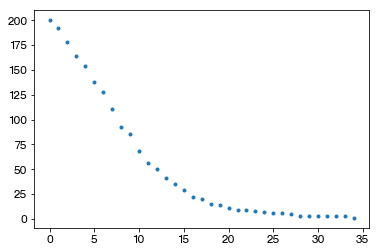

0.1516300227445034 0.10678056593699946


In [16]:
movie_stats = pd.read_csv('C:/Users/Bas/Google Drive/Bas Games/Analysis/Turing/turing_movie_stats.txt',
                          header=None,names=['id','n','bp','wp'],delimiter='\t')
x=[sum(movie_stats.groupby('id').n.transform(lambda x: x-min(x))==k) for k in range(1,36)]
plt.plot(x,'.')
plt.show()

print(1/movie_stats.groupby('id').n.min().mean(),
      1/(movie_stats.groupby('id').n.max()-movie_stats.groupby('id').n.min()).mean())



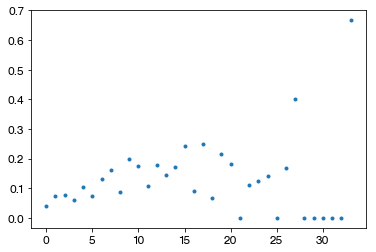

In [17]:
plt.plot([1-x/y for x,y in zip(x[1:],x[:-1])],'.')

plt.show()

In [18]:
data=pd.read_csv(direc2 + 'turing_responses.txt', sep=',',header=0)
data_resp=data.values[:,1:].astype(float)
mean_percent_correct = np.mean(data_resp[:,3])

In [19]:
vid_stats_norm[['clip_id','ave_eucl','clip_type','length','block missed','win missed','error_rate','loglik']].groupby('clip_type').mean().reset_index()

,clip_type,clip_id,ave_eucl,length,block missed,win missed,error_rate,loglik
0,-0.997218,-0.010236,0.031214,-0.174497,0.179468,0.076259,-0.015007,0.07301
1,0.997218,0.010236,-0.031214,0.174497,-0.179468,-0.076259,0.015007,-0.07301


In [20]:
vid_stats[['clip_id','ave_eucl','category_reported','length','block missed','win missed','error_rate','loglik']].groupby('category_reported').mean().reset_index()

,category_reported,clip_id,ave_eucl,length,block missed,win missed,error_rate,loglik
0,0,78.857143,2.329691,8.042857,0.514286,0.042857,0.174530,1.822527
1,1,96.272727,2.488960,10.572727,0.618182,0.054545,0.208353,1.797182


In [21]:
def train_logistic(target,regressors,pred_name):
    logit = sm.Logit(vid_stats[target], vid_stats_norm[regressors])
    result=logit.fit(disp=0)
    predictions = result.predict()
    predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
    vid_stats[pred_name] = predictions_nominal
    #conf = result.conf_int()
    #conf['OR'] = params
    #conf.columns = ['2.5%', '97.5%', 'OR']
    return result

In [22]:
train_cols = ['loglik','block missed','start_pieces','ave_eucl','win missed','error_rate','length']
questions = [0,1,4,6,7,8]

result = train_logistic('clip_type',train_cols,'true_pred')
beta_correct = np.array(result.params)
conf_correct = np.array(result.conf_int())

results = [train_logistic('choice_' + str(i),train_cols,'report_pred_' + str(i)) for i in range(30)]
beta_choice = np.array([r.params for r in results])

#print(result.summary())
#print np.exp(result.params)
#print np.exp(conf)
#print(predictions_nominal)
#print(confusion_matrix(vid_stats['clip_type'], predictions_nominal))
#print(classification_report(vid_stats['clip_type'], predictions_nominal, digits=3))


loglik -0.0890939272463 ± 0.0627001523835
block missed -0.262906818185 ± 0.0456680967194
start_pieces 0.0993175214623 ± 0.0291864884467
ave_eucl -0.0466352424706 ± 0.0329909881369
win missed -0.114240183673 ± 0.0274443384949
error_rate 0.0499871886597 ± 0.0250944559375
length 0.326740113175 ± 0.0652274995461


C:\Users\Bas\Anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:1121: UserWarning: 'HelveticaNeueLTStd-Ex_0.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


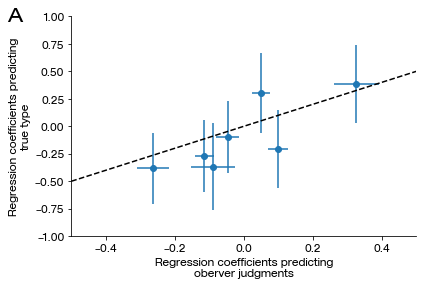

SpearmanrResult(correlation=0.85714285714285732, pvalue=0.01369732661532562)


In [23]:
for i,col in enumerate(train_cols):
    #print(col,np.mean(beta_choice[:,i]),np.std(beta_choice[:,i])/np.sqrt(30),
    #      'p:',sts.ttest_1samp(beta_choice[:,i],popmean=0).pvalue,
    #      beta_correct[i],conf_correct[i])
    print(col,np.mean(beta_choice[:,i]),"±",np.std(beta_choice[:,i])/np.sqrt(30))
    
fig,ax=plt.subplots()
ax.set_xlabel('Regression coefficients predicting\noberver judgments')
ax.set_ylabel('Regression coefficients predicting\ntrue type')
ax.errorbar(x=np.mean(beta_choice,axis=0),y=beta_correct,
             xerr=np.std(beta_choice,axis=0)/np.sqrt(30),
             yerr=[conf_correct[:,0]-beta_correct,beta_correct-conf_correct[:,1]],fmt='o')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.02, 0.95, 'A', horizontalalignment='left',
    verticalalignment='center', transform=fig.transFigure, fontsize = 20)
ax.plot([-0.5,0.5],[-0.5,0.5],'k',linestyle='dashed')
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-1,1])
fig.tight_layout()
plt.savefig(fig_direc + 'turing_regress_betas_A.pdf')
plt.show()

print(sts.spearmanr(np.mean(beta_choice,axis=0),beta_correct))

C:\Users\Bas\Anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:1121: UserWarning: 'HelveticaNeueLTStd-Ex_0.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


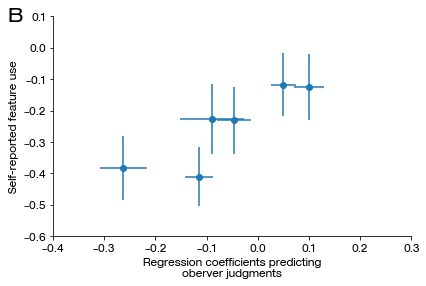

SpearmanrResult(correlation=0.82857142857142874, pvalue=0.041562682215743343)


In [24]:
turingQ = pd.read_csv(direc+'turingQ.csv')
self_report = [turingQ['q'+str(i)]/50-1 for i in questions]
self_report_mean = [s.mean() for s in self_report]
self_report_sem = [s.std()/np.sqrt(29) for s in self_report]

fig,ax=plt.subplots()
ax.set_xlabel('Regression coefficients predicting\noberver judgments')
ax.set_ylabel('Self-reported feature use')
ax.errorbar(x=np.mean(beta_choice,axis=0)[:-1],y=self_report_mean,
             xerr=np.std(beta_choice,axis=0)[:-1]/np.sqrt(30),
             yerr=self_report_sem,fmt='o')
ax.text(0.02, 0.95, 'B', horizontalalignment='left',
    verticalalignment='center', transform=fig.transFigure, fontsize = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot([-0.5,0.5],[-0.5,0.5],linestyle='dashed')
ax.set_xlim([-0.4,0.3])
ax.set_ylim([-0.6,0.1])
fig.tight_layout()
plt.savefig(fig_direc + 'turing_regress_betas_B.pdf')
plt.show()

print(sts.spearmanr(np.mean(beta_choice,axis=0)[:-1],self_report_mean))

In [25]:
percent_correct = [(vid_stats['report_pred_' + str(i)]==vid_stats['choice_' + str(i)]).mean() for i in range(30)]
print(np.mean(percent_correct),np.std(percent_correct)/np.sqrt(30))

0.619074074074 0.00955341396233


In [26]:
self_report_mean

[-0.2275862068933333,
 -0.3827586206866667,
 -0.12413793103333334,
 -0.2310344827600001,
 -0.4103448275866667,
 -0.11724137931333335]

In [27]:
conf=np.abs(data_resp[:,2]-50)
clip=data_resp[:,0].astype(int)
l=(np.bincount(clip,weights=data_resp[:,1])/30).astype(int)
player = data.values[:,0]

c=data_resp[:,3]
c_ave=np.bincount(clip,weights=c)/np.bincount(clip)
c_ave2=np.bincount(clip,weights=conf*c)/np.bincount(clip,weights=conf)
A=np.vstack([c[clip==i][np.argsort(conf[clip==i])] for i in range(0,180)])
c_ave3=np.mean(A[:,-5:],axis=1)
c_class = np.array(vid_stats['true_pred']==vid_stats['clip_type'])

Optimization terminated successfully.
         Current function value: 0.684525
         Iterations 4
[-0.03474381  1.10833864]
[  5.07511978e-01   2.77711769e-08]


C:\Users\Bas\Anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:1121: UserWarning: 'HelveticaNeueLTStd-Ex_0.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


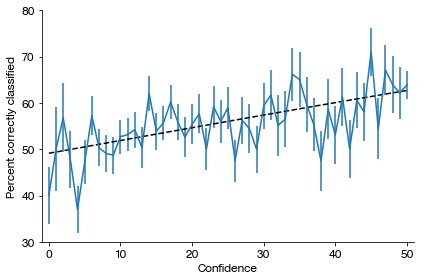

In [28]:
n = np.bincount(conf.astype(int))
m = 100*np.bincount(conf.astype(int),weights=c)/n
e = np.sqrt(np.bincount(conf.astype(int),weights=(100*c)**2)/n-m**2)/np.sqrt(n)

model = sm.Logit(c,add_constant(conf/100)).fit()
print(model.params)
print(model.pvalues)
x = np.arange(0,50,0.1)
y = 100*model.predict(exog=add_constant(x/100))

beta1,beta2 = model.params

fig,ax=plt.subplots()
ax.set_xlabel('Confidence')
ax.set_ylabel('Percent correctly classified')
ax.set_ylim([30,80])
ax.set_xlim([-1,51])
ax.errorbar(range(51),m,yerr=e)
ax.plot(x,y,'k--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(fig_direc + 'turing_A.pdf')
plt.show()

In [29]:
model = ols("y ~ conf", pd.DataFrame({'conf':conf,'y':c})).fit()
print(model.params)
print(model.pvalues)

Intercept    0.491985
conf         0.002717
dtype: float64
Intercept    4.571448e-281
conf          2.497202e-08
dtype: float64


C:\Users\Bas\Anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:1121: UserWarning: 'HelveticaNeueLTStd-Ex_0.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


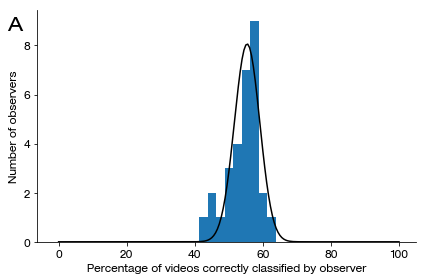

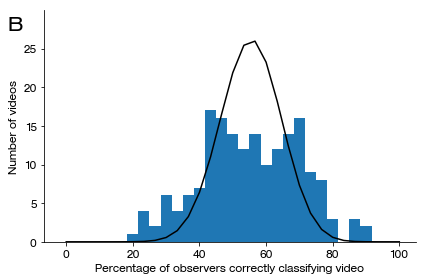

In [30]:
observer_accuracy = data.groupby('user_name').mean()['feedback'].values
clip_ncorrect = data.groupby('clip_id').sum()['feedback'].values

fig,ax=plt.subplots()
ax.set_xlabel('Percentage of videos correctly classified by observer')
ax.set_ylabel('Number of observers')
binsize=0.025
ax.bar(left=100*np.arange(0,1,binsize),height=np.histogram(observer_accuracy,
         bins=np.arange(0,1+binsize,binsize),normed=False)[0],width=100*binsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.02, 0.9, 'A', horizontalalignment='left',
    verticalalignment='center', transform=fig.transFigure, fontsize = 20)

bins=np.arange(0,181,1)
ax.plot(100*bins/180,binsize*180*30*sts.binom.pmf(bins,180,mean_percent_correct),color='black')
fig.tight_layout()
fig.savefig(fig_direc + 'histo_turing_A.pdf')
plt.show()

fig,ax=plt.subplots()
ax.set_xlabel('Percentage of observers correctly classifying video')
ax.set_ylabel('Number of videos')
ax.bar(left=100*np.arange(0,30,1)/30,height=np.histogram(clip_ncorrect,
         bins=np.arange(0,31,1),normed=False)[0],width=100/30)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.02, 0.9, 'B', horizontalalignment='left',
    verticalalignment='center', transform=fig.transFigure, fontsize = 20)
ax.set_ylim([0,30])
ax.set_yticks(np.arange(0,30,5))
bins=np.arange(0,31,1)
ax.plot(100*bins/30,180*sts.binom.pmf(bins,30,mean_percent_correct),color='black')
fig.tight_layout()
fig.savefig(fig_direc + 'histo_turing_B.pdf')
plt.show()




In [31]:
print(100*np.mean(observer_accuracy),100*np.std(observer_accuracy)/np.sqrt(np.prod(observer_accuracy.shape)),
     100*np.percentile(observer_accuracy,25),100*np.percentile(observer_accuracy,75))

55.3518518519 0.89061689034 52.9166666667 59.3055555556


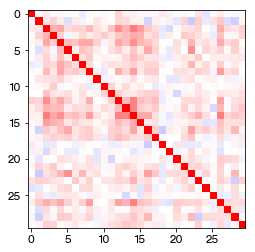

0.148326652034 0.0116609935523


In [32]:
from sklearn.cluster import dbscan
response_clip_observer = np.reshape(data.sort_values(['user_name','clip_id'])
                                    .values[:,3].astype('float'),[30,180])
M = np.corrcoef(response_clip_observer)

fig,ax=plt.subplots()
ax.imshow(M,vmin=-1,vmax=1,cmap='bwr',interpolation='nearest')

plt.show()
rho = np.corrcoef(response_clip_observer)[np.triu_indices(30)]

print(np.mean(rho),np.std(rho)/np.sqrt(np.prod(rho.shape)))

In [36]:
#def f(n):
#    return (n*(n-1) + (30-n)*(29-n))/30/29
#np.mean([f(n) for n in np.sum(feedback_clip_observer,axis=0)])

In [34]:
def f(info,c):
    return np.sum([np.log(1+np.exp(-ll*info)) if cc==1 else np.log(1+np.exp(ll*info)) 
               for ll,cc in zip(l,c>0.5)])

def get_ihat(c):
    i=np.arange(-0.1,0.1,0.0001)
    return i[np.argmin([f(x,c) for x in i])]
    
lsort=np.sort(l)
ihat = [get_ihat(cc) for cc in [c_ave,c_ave2,c_ave3,c_class]]

C:\Users\Bas\Anaconda3\lib\site-packages\matplotlib\backends\backend_pdf.py:1121: UserWarning: 'HelveticaNeueLTStd-Ex_0.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


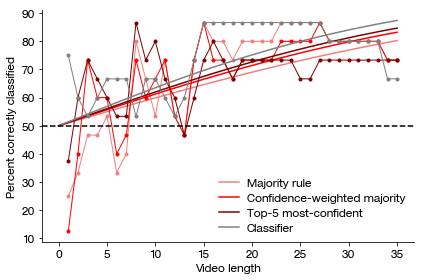

[0.040100000000003994, 0.045800000000004171, 0.048900000000004246, 0.055400000000004446]


In [61]:
fig,ax=plt.subplots()
ax.set_xlabel('Video length')
ax.set_ylabel('Percent correctly classified')
for i,cc,color,label in zip(ihat,[c_ave,c_ave2,c_ave3,c_class],['lightcoral','red','maroon','gray'],
                      ['Majority rule','Confidence-weighted majority','Top-5 most-confident','Classifier']):
    csort=cc[np.argsort(l)]>0.5
    ax.plot(range(1,36),[100*np.mean(csort[lsort<=n][-15:]) for n in range(1,36)],'.-',linewidth=1,color=color)
    ax.plot([100/(1+np.exp(-n*i)) for n in range(0,36)],color = color,label = label)    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(50,linestyle='dashed',color='black')
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig(fig_direc + 'turing_psycho.pdf')
plt.show()
    
print(ihat)

In [ ]:
list(zip(np.mean(beta_choice,axis=1),beta_correct,self_report_mean))

In [ ]:
tur['reported_weighted'] = 2*(tur.human-0.5) * tur.delta_c / 100
tur_vid = tur.groupby('clip_id').mean().reset_index()
vid_stats['reported_weighted'] = tur_vid['reported_weighted']
vid_stats['correct_weighted'] = (((vid_stats.reported_weighted<0) & (vid_stats.clip_type==0)) | ((vid_stats.reported_weighted>=0) & (vid_stats.clip_type==1)))
vid_stats_len = vid_stats.groupby('length').mean().reset_index()
tur_l = tur.groupby('length').mean().reset_index()

In [ ]:
vid_stats.correct_weighted.mean()

In [ ]:
print((vid_stats['category_reported']==vid_stats['clip_type']).mean())

In [ ]:
# figure of true type predicted vs length, and reported type vs length

fig, axes = plt.subplots(1, 1, figsize=(15,8))

plt.plot(tur_l['length'], tur_l['feedback'], color='red',label='Average')
plt.plot(vid_stats_len['length'],vid_stats_len['correct_weighted'],color='g',label='Weighted Average by Confidence')
plt.plot(vid_stats_len['length'],vid_stats_len['true_pred'],color='b',label='Optimal')

plt.setp(
    axes, 
    xlabel='Video Length', ylabel='Percentage correct'
)

plt.legend()

sns.despine()

In [ ]:
# figure of true type predicted vs length, and reported type vs length
fig, axes = plt.subplots(1, 1, figsize=(10,6))

plt.plot(vid_stats_len['length'],vid_stats_len['reported_pred'],color='r')

plt.setp(
    axes, 
    xlabel='Video Length', ylabel='Percentage correct'
)

sns.despine()

In [ ]:
# sig correaltion between reporting human and whether there is a block missed
# not for percentage correct
# less sig for 


vidstat_type = dict()
for i in range(0,2,1):
    vidstat_type[i] = vid_stats.loc[vid_stats['block missed']==i]
y = [np.mean(vidstat_type[i]['human']) for i in range(0,2,1)]
yerr = [np.std(vidstat_type[i]['human'])/np.sqrt(30) for i in range(0,2,1)]
types=[0,1]
axes.errorbar(types, y, yerr,alpha=0.6)

slope, intercept, r_value, p_value, std_err = sts.linregress(vid_stats['block missed'], vid_stats['human'])
print(slope,r_value,p_value)


fig, axes = plt.subplots(1, 1, figsize=(8,6))

plt.scatter(vid_stats['block missed'], vid_stats['human'],color='steelblue')
vid_stats_a = vid_stats.groupby('block missed').mean().reset_index()
plt.scatter(vid_stats_a['block missed'], vid_stats_a['human'],s=80,color='salmon')

#axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='Reporting human', xlabel='block missed'
)

sns.despine()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))

vidstat_type = dict()
for i in range(0,2,1):
    vidstat_type[i] = vid_stats.loc[vid_stats['block missed']==i]
y = [np.mean(vidstat_type[i]['delta_c']) for i in range(0,2,1)]
yerr = [np.std(vidstat_type[i]['delta_c'])/np.sqrt(30) for i in range(0,2,1)]
types=[0,1]
axes.errorbar(types, y, yerr,alpha=0.6)

slope, intercept, r_value, p_value, std_err = sts.linregress(vid_stats['block missed'], vid_stats['delta_c'])
print(slope,r_value,p_value)

plt.scatter(vid_stats['block missed'], vid_stats['delta_c'],color='steelblue')
#plt.scatter(tur_t.clip_type, tur_t.feedback,s=80,color='salmon')

#axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='delta c', xlabel='block missed'
)

sns.despine()

In [ ]:
# sig correaltion between reporting human and whether a win is seen
# not for percentage correct
# less sig for confidence and whether there is a block missed

fig, axes = plt.subplots(1, 1, figsize=(8,6))

vidstat_type = dict()
for i in range(0,2,1):
    vidstat_type[i] = vid_stats.loc[vid_stats['win']==i]
y = [np.mean(vidstat_type[i]['human']) for i in range(0,2,1)]
yerr = [np.std(vidstat_type[i]['human'])/np.sqrt(30) for i in range(0,2,1)]
types=[0,1]
axes.errorbar(types, y, yerr,alpha=0.6)

slope, intercept, r_value, p_value, std_err = sts.linregress(vid_stats['win'], vid_stats['human'])
print(slope,r_value,p_value)

plt.scatter(vid_stats['win'], vid_stats['human'],color='steelblue')
vid_stats_a = vid_stats.groupby('win').mean().reset_index()
plt.scatter(vid_stats_a['win'], vid_stats_a['human'],s=80,color='salmon')

#axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='Reporting human', xlabel='win'
)

sns.despine()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))

vidstat_type = dict()
for i in range(0,2,1):
    vidstat_type[i] = vid_stats.loc[vid_stats['win']==i]
y = [np.mean(vidstat_type[i]['delta_c']) for i in range(0,2,1)]
yerr = [np.std(vidstat_type[i]['delta_c'])/np.sqrt(30) for i in range(0,2,1)]
types=[0,1]
axes.errorbar(types, y, yerr,alpha=0.6)

slope, intercept, r_value, p_value, std_err = sts.linregress(vid_stats['win'], vid_stats['delta_c'])
print(slope,r_value,p_value)

plt.scatter(vid_stats['win'], vid_stats['delta_c'],color='steelblue')
#plt.scatter(tur_t.clip_type, tur_t.feedback,s=80,color='salmon')

#axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='delta c', xlabel='win'
)

sns.despine()

In [ ]:
# check ave Euclidean distance: now it is not colinear with length of video
fig, axes = plt.subplots(1, 1, figsize=(8,6))

slope, intercept, r_value, p_value, std_err = sts.linregress(vid_stats['length'], vid_stats['ave_eucl'])
print(slope,r_value,p_value)

plt.scatter(vid_stats['length'], vid_stats['ave_eucl'],color='steelblue')
#plt.scatter(tur_t.clip_type, tur_t.feedback,s=80,color='salmon')

#axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='Average Euclidean distance',xlabel='length'
)

sns.despine()